## Reddit data-set for sarcasm detection

The Sarcasm on Reddit dataset provides comments posted on Reddit labeled as sarcastic (1) or not sarcastic (0).
The task of the project is, given only the parent comment and the Reddit category (subreddit), to predict the probability of a parent comment to receive a sarcastic comment.

Download the dataset and unzip it.

In [ ]:
# import kaggle
# kaggle.api.authenticate()
# kaggle.api.dataset_download_files('danofer/sarcasm', unzip=True)

In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression as lg
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib
from matplotlib import pyplot as plt
from scipy.sparse import hstack
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [2]:
import tensorflow as tf
import os
from tensorflow import keras

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.0


In [3]:
# Importing the Keras libraries and packages
from keras import backend as K
from keras.utils import to_categorical
from keras.layers import Dense, ZeroPadding2D, AveragePooling2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import InceptionResNetV2
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [4]:
import spacy
spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser = English()

### Data-set analysis

We import the data and analyze it.

As the creator of the dataset states the Reddit dataset contains 1.3 million Sarcastic comments from the Internet commentary website Reddit and it was generated by scraping comments from Reddit containing the \s (sarcasm) tag. This tag is often used by Redditors to indicate that their comment is in jest and not meant to be taken seriously, and is generally a reliable indicator of sarcastic comment content.

In [5]:
red = pd.read_csv('C:/Users/liry9/Desktop/Text Mining and Sentiment Analysis/Project/Dataset/train-balanced-sarcasm.csv')
red.head(10)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
5,0,"I don't pay attention to her, but as long as s...",only7inches,AskReddit,0,0,0,2016-09,2016-09-02 10:35:08,do you find ariana grande sexy ?
6,0,Trick or treating in general is just weird...,only7inches,AskReddit,1,-1,-1,2016-10,2016-10-23 21:43:03,What's your weird or unsettling Trick or Treat...
7,0,Blade Mastery+Masamune or GTFO!,P0k3rm4s7,FFBraveExvius,2,-1,-1,2016-10,2016-10-13 21:13:55,Probably Sephiroth. I refuse to taint his grea...
8,0,"You don't have to, you have a good build, buy ...",SoupToPots,pcmasterrace,1,-1,-1,2016-10,2016-10-27 19:11:06,What to upgrade? I have $500 to spend (mainly ...
9,0,I would love to see him at lolla.,chihawks,Lollapalooza,2,-1,-1,2016-11,2016-11-21 23:39:12,Probably count Kanye out Since the rest of his...


In [6]:
print(red.shape[0])  # gives number of row count
print(red.shape[1])  # gives number of col count

1010826
10


The analysis will begin by focusing on a small sample of the dataset since as it is possible to observe from the previous command the dataset (not yet pre-processed) contains 1010826 rows, 962295 unique values (as for what concerns the comments' column) and 984286 unique values (for the parent comment section). The difference between the total number of rows of the data frame, that of the comments and the ones of the parent comments implies that there are some nan values. As a matter of fact:

In [7]:
red.isnull().sum() # There are 53 nan values for the comments' column

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

In [8]:
red = red[red['comment'].notna()]
red.isnull().sum()

label             0
comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

In [9]:
red_sample = red.sample(frac = 0.05) ## Since the original dataset is huge, we will work with a small sample of it
print(red_sample.shape[0])  # gives number of row count
print(red_sample.shape[1])  # gives number of col count

50539
10


In [10]:
## Let's check the number of unique values in the label columns: this operation should confirm that we only have two labels:
# 0 = non sarcastic comment
# 1 = sarcastic comment
red_sample['label'].nunique()

2

Based on the information given by its owner the dataset should be balanced, this however an analysis of the distribution of the labels will follow, in order to check whether we need to adjust the class distribution of our dataset using adapting techniques such as oversampling or undersampling.

C:\Users\liry9\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

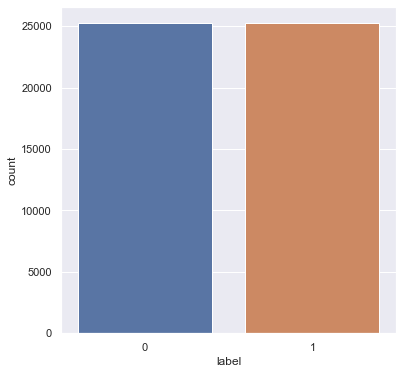

In [11]:
sns.set(rc={'figure.figsize':(6,6)})
sns.countplot(red_sample['label']) # The dataset, or in this case the sample, is confirmed to be balanced

## Distribution of sarcastic and non sarcastic comments

In order to compute what is the probability that given only the subreddit and the parent comment, the parent comment is associated with a sarcastic comment it is necessary to drop all the other columns.

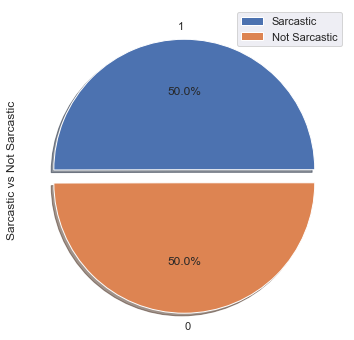

In [12]:
# Pie chart
red_sample["label"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Sarcastic vs Not Sarcastic")
plt.legend(["Sarcastic", "Not Sarcastic"])
plt.show()

### Exploratory Analysis

It might be interesting to perform some exploratory analysis on the dataset.

In [13]:
## Number of unique comment author
red_sample['author'].nunique()

41902

In [14]:
## Number of unique subreddit
red_sample['subreddit'].nunique()

4050

In [15]:
# Create a copy of the original dataset
red_copy = red_sample.copy()

Focusing on the column of the comments.

In [16]:
## Group and count the comments by author and label
red_sample.groupby(['author', 'label'],as_index=False).agg({'comment':'count'})

,author,label,comment
0,--------__--------,0,1
1,--------__--------,1,1
2,---Earth---,0,1
3,--Dawn--,0,1
4,--MrsNesbitt-,1,1
...,...,...,...
45803,zzed_41,0,1
45804,zzed_41,1,1
45805,zzt711,0,1
45806,zzzzzzzzzzzzzzzzspaf,0,1


In [17]:
## Return the number of sarcastic comment per each author
sarcasm_count_by_author = red_sample.groupby('author')['label'].agg([np.sum])
sarcasm_count_by_author

,sum
author,
--------__--------,1
---Earth---,0
--Dawn--,0
--MrsNesbitt-,1
--Quartz--,1
...,...
zyk0s,0
zynxm8,1
zzed_41,1


In [18]:
## Group and count the comments by author
comment_count_by_author = red_sample.groupby(['author'],as_index=False).agg({'comment':'count'})
comment_count_by_author

,author,comment
0,--------__--------,2
1,---Earth---,1
2,--Dawn--,1
3,--MrsNesbitt-,1
4,--Quartz--,1
...,...,...
41897,zyk0s,1
41898,zynxm8,1
41899,zzed_41,2
41900,zzt711,1


In [19]:
comment_sum_up = pd.merge(sarcasm_count_by_author, comment_count_by_author, on='author')
comment_sum_up

,author,sum,comment
0,--------__--------,1,2
1,---Earth---,0,1
2,--Dawn--,0,1
3,--MrsNesbitt-,1,1
4,--Quartz--,1,1
...,...,...,...
41897,zyk0s,0,1
41898,zynxm8,1,1
41899,zzed_41,1,2
41900,zzt711,0,1


In [20]:
comment_sum_up['percentage of sarcastic comments'] = comment_sum_up['sum']/comment_sum_up['comment']
comment_sum_up

,author,sum,comment,percentage of sarcastic comments
0,--------__--------,1,2,0.5
1,---Earth---,0,1,0.0
2,--Dawn--,0,1,0.0
3,--MrsNesbitt-,1,1,1.0
4,--Quartz--,1,1,1.0
...,...,...,...,...
41897,zyk0s,0,1,0.0
41898,zynxm8,1,1,1.0
41899,zzed_41,1,2,0.5
41900,zzt711,0,1,0.0


In [21]:
## Most sarcastic author:
print("The most sarastic author is: %15s" % (comment_count_by_author['author'].loc[comment_count_by_author['comment'].idxmax()]))

The most sarastic author is:     Biffingston


Some further analysis

In [22]:
## Group and count the comments by author and label
red_sample.groupby(['subreddit', 'label'],as_index=False).agg({'comment':'count'})

,subreddit,label,comment
0,100DaysofKeto,0,1
1,10cloverfieldlane,1,1
2,112263Hulu,0,1
3,1200isplenty,0,1
4,18bfriendzonest,0,1
...,...,...,...
5720,zen,1,1
5721,zenfone2,0,1
5722,zombies,0,4
5723,zootopia,0,2


In [23]:
## Return the number of sarcastic comment per each subreddit
sarcasm_count_by_subreddit = red_sample.groupby('subreddit')['label'].agg([np.sum])
sarcasm_count_by_subreddit

,sum
subreddit,
100DaysofKeto,0
10cloverfieldlane,1
112263Hulu,0
1200isplenty,0
18bfriendzonest,0
...,...
zelda,9
zen,1
zenfone2,0


In [24]:
## Group and count the comments by author
comment_count_by_subreddit = red_sample.groupby(['subreddit'],as_index=False).agg({'comment':'count'})
comment_count_by_subreddit

,subreddit,comment
0,100DaysofKeto,1
1,10cloverfieldlane,1
2,112263Hulu,1
3,1200isplenty,1
4,18bfriendzonest,1
...,...,...
4045,zelda,12
4046,zen,3
4047,zenfone2,1
4048,zombies,4


In [25]:
subreddit_comment_sum_up = pd.merge(sarcasm_count_by_subreddit, comment_count_by_subreddit, on='subreddit')
subreddit_comment_sum_up

,subreddit,sum,comment
0,100DaysofKeto,0,1
1,10cloverfieldlane,1,1
2,112263Hulu,0,1
3,1200isplenty,0,1
4,18bfriendzonest,0,1
...,...,...,...
4045,zelda,9,12
4046,zen,1,3
4047,zenfone2,0,1
4048,zombies,0,4


In [26]:
subreddit_comment_sum_up['percentage of sarcastic comments'] = subreddit_comment_sum_up['sum']/subreddit_comment_sum_up['comment']
subreddit_comment_sum_up

,subreddit,sum,comment,percentage of sarcastic comments
0,100DaysofKeto,0,1,0.000000
1,10cloverfieldlane,1,1,1.000000
2,112263Hulu,0,1,0.000000
3,1200isplenty,0,1,0.000000
4,18bfriendzonest,0,1,0.000000
...,...,...,...,...
4045,zelda,9,12,0.750000
4046,zen,1,3,0.333333
4047,zenfone2,0,1,0.000000
4048,zombies,0,4,0.000000


In [27]:
## Most sarcastic subreddit
print("The most sarastic subreddit is: %15s" % (comment_count_by_subreddit['subreddit'].loc[comment_count_by_subreddit['comment'].idxmax()]))

The most sarastic subreddit is:       AskReddit


In [28]:
subreddits = red_sample['subreddit'].value_counts()

In [29]:
pd.DataFrame(subreddits)

,subreddit
AskReddit,3255
politics,1922
worldnews,1322
leagueoflegends,1031
pcmasterrace,978
...,...
jambands,1
mightyboosh,1
DeadNiggaStorage,1
DestinyMaps,1


In [30]:
top_ten = subreddits.head(10)
top_ten = pd.DataFrame(top_ten)

In [31]:
top_ten['sub'] = top_ten.index

In [32]:
top_ten

,subreddit,sub
AskReddit,3255,AskReddit
politics,1922,politics
worldnews,1322,worldnews
leagueoflegends,1031,leagueoflegends
pcmasterrace,978,pcmasterrace
funny,897,funny
pics,831,pics
news,821,news
nfl,726,nfl
GlobalOffensive,716,GlobalOffensive


In [33]:
top_ten = top_ten.reset_index(drop=True)
top_ten

,subreddit,sub
0,3255,AskReddit
1,1922,politics
2,1322,worldnews
3,1031,leagueoflegends
4,978,pcmasterrace
5,897,funny
6,831,pics
7,821,news
8,726,nfl
9,716,GlobalOffensive


In [34]:
df = red_sample[red_sample.set_index(['subreddit']).index.isin(top_ten.set_index(['sub']).index)]
df = pd.DataFrame(df)

In [35]:
df

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
927917,0,Couldn't be bothered with redelivering; hid un...,BarfingBear,funny,1,1,0,2013-12,2013-12-02 15:40:59,Pretty much like UPS.
870285,0,- or both?,midway0512,politics,3,3,0,2014-09,2014-09-09 15:43:15,"This man is either a lunatic, or knows his aud..."
14991,0,Genie,RehneDe,AskReddit,1,1,0,2016-09,2016-09-13 17:19:47,What comes to your mind when you hear the word...
819162,0,Doubtful - we have rules around owning exotic ...,nath1234,funny,-3,-3,0,2014-02,2014-02-23 04:14:33,Are these what pets look like in Australia?
155245,0,you all speak like this doesn't actually happen.,BigBnana,AskReddit,1,-1,-1,2016-11,2016-11-17 02:49:11,And maintain eye contact when saying it......o...
...,...,...,...,...,...,...,...,...,...,...
429994,1,You'll be sorry when he builds a wall!,YakinRaptor,AskReddit,1,1,0,2016-03,2016-03-09 02:57:55,we managed with bush twice AND Harper being ou...
634855,0,You can begin by taking proper screenshot like...,Funkka,pcmasterrace,2,2,0,2015-05,2015-05-12 20:56:00,I don't even know where to begin
827297,0,That was a fucking brilliant story.,Thundaa_Gaming,AskReddit,1,1,0,2014-01,2014-01-14 19:56:27,I have no idea what the fuck was with my schoo...
683840,1,You forgot the,manfox,worldnews,2,2,0,2015-03,2015-03-27 22:35:23,Because war and conflict is bad for business f...


C:\Users\liry9\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'Sarcastic comments for AskReddit')]

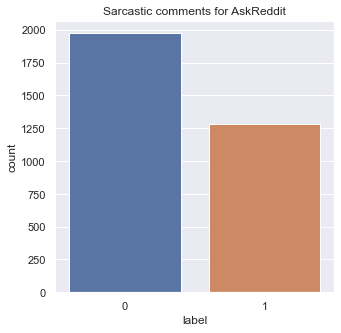

In [36]:
df_AskReddit = red_sample[red_sample['subreddit']==top_ten['sub'][0]]
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(df_AskReddit['label']).set(title = 'Sarcastic comments for AskReddit')

C:\Users\liry9\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'Sarcastic comments for "politics"')]

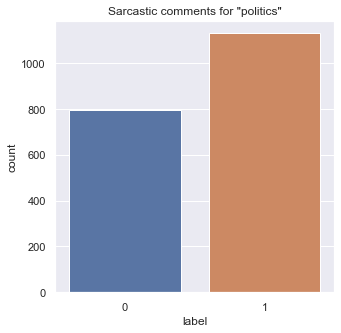

In [37]:
df_politics = red_sample[red_sample['subreddit']==top_ten['sub'][1]]
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(df_politics['label']).set(title = 'Sarcastic comments for "politics"')

C:\Users\liry9\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'Sarcastic comments for "worldnews"')]

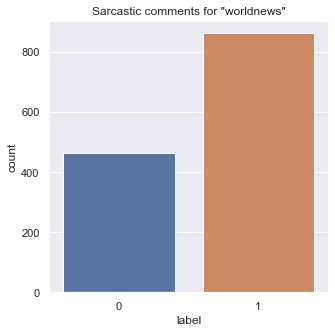

In [38]:
df_worldnews = red_sample[red_sample['subreddit']==top_ten['sub'][2]]
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(df_worldnews['label']).set(title = 'Sarcastic comments for "worldnews"')

C:\Users\liry9\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'Sarcastic comments for "leagueoflegends"')]

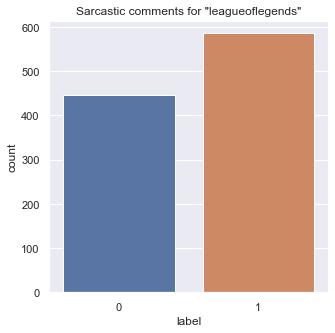

In [39]:
df_leagueoflegends = red_sample[red_sample['subreddit']==top_ten['sub'][3]]
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(df_leagueoflegends['label']).set(title = 'Sarcastic comments for "leagueoflegends"')

C:\Users\liry9\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'Sarcastic comments for "leagueoflegends"')]

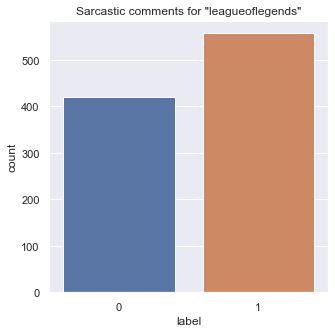

In [40]:
df_leagueoflegends = red_sample[red_sample['subreddit']==top_ten['sub'][4]]
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(df_leagueoflegends['label']).set(title = 'Sarcastic comments for "leagueoflegends"')

Let's print out the highest and the lowest scores first and then the corresponding comment and parent comment.

In [41]:
print("The minimum score assigned to a comment is %d, while the highest one is %d" % (red_sample['score'].min(), red_sample['score'].max()))

The minimum score assigned to a comment is -143, while the highest one is 4776


In [42]:
print('The Parent Comment of the comment with the highest score is:\n',red_sample['parent_comment'].loc[red_sample['score'].idxmax()])
print('\n The Comment with the highest score is:\n',red_sample['comment'].loc[red_sample['score'].idxmax()])
if red_sample['label'].loc[red_sample['score'].idxmax()]==1:
    print('\n sarcastic')
else:
    print('\n not sarcastic')

The Parent Comment of the comment with the highest score is:
 oh god. I have had several awkward tinder dates. the worst was this guy who was 23 and had pretty much grown up on the computer. usually don't mind guys having a gaming hobby. any hobby is great as it shows you have a passion for something. but it should be a hobby it shouldn't rule your life. anyway I offered to meet him at the uni we both attended to grab a coffee, but he insisted on going to the local shopping complex despite the fact that he didn't drive. no idea how he got there. he ended up being around 30 mins late. ok. I can deal with that. when we finally meet he's so nervous he's shaking like a Chihuahua. and barely able to speak. I get it. first dates can be nerve-wracking. we sit down to sushi and there is absolute dead silence. I start asking him questions to start the conversation but all I get is 2 word replies...right. this is getting a bit more frustrating.I even ask him questions about what games he likes (

In [43]:
## Lowest score comment and its parent comment
print('The Parent Comment of the comment with the lowest score is:\n',red_sample['parent_comment'].loc[red_sample['score'].idxmin()])
print('\n The Comment with the lowest score is:\n',red_sample['comment'].loc[red_sample['score'].idxmin()])
if red_sample['label'].loc[red_sample['score'].idxmin()]==1:
    print('\n sarcastic')
else:
    print('\n not sarcastic')

The Parent Comment of the comment with the lowest score is:
 That swag shit in the beginning is fucking stupid

 The Comment with the lowest score is:
 Yeah, it is, but you still have to respect it because it's culture!

 sarcastic


Analysis on the scores

In [44]:
# Mean and STD of Score Rating
mean = red_sample['score'].mean()
std = red_sample['score'].std()
print(mean, std)

6.921328083262431 50.18436727778287


### Text exploratory analysis

In [45]:
list(red_sample.columns)

['label',
 'comment',
 'author',
 'subreddit',
 'score',
 'ups',
 'downs',
 'date',
 'created_utc',
 'parent_comment']

In [46]:
red_copy.drop(['comment', 'author', 'score', 'ups', 'downs', 'date', 'created_utc'], axis=1, inplace=True)
red_copy.head(10)

,label,subreddit,parent_comment
629463,0,beerporn,Pink beer.
55300,1,xboxone,ReCore Pancake - Joule and Mack | Xbox
680174,0,Planetside,Day...Break?
354102,0,gaming,"Just stop walking, point the gun at their head..."
927917,0,funny,Pretty much like UPS.
712984,0,Music,I missed it what did he do?
368481,1,washingtondc,"4/20 Activities In town for the week, and I'm ..."
598718,0,TheFrontBottoms,"the price of the album was 17.99 i think, it s..."
364868,0,sandiego,"Looking to buy a house in the Santee area, is ..."
870285,0,politics,"This man is either a lunatic, or knows his aud..."


In [47]:
# Find the number of characters for each string in the red_sample dataset
red_copy['char'] = red_copy['parent_comment'].str.len()
red_copy.head()

,label,subreddit,parent_comment,char
629463,0,beerporn,Pink beer.,10
55300,1,xboxone,ReCore Pancake - Joule and Mack | Xbox,38
680174,0,Planetside,Day...Break?,12
354102,0,gaming,"Just stop walking, point the gun at their head...",105
927917,0,funny,Pretty much like UPS.,21


In [48]:
def plotDistr(var):
    plt.hist(red_copy[var][red_copy['label']==0], density=True, label='Not Sarcastic')
    plt.hist(red_copy[var][red_copy['label']==1], density=True, label='Sarcastic')
    plt.legend()
    plt.show()

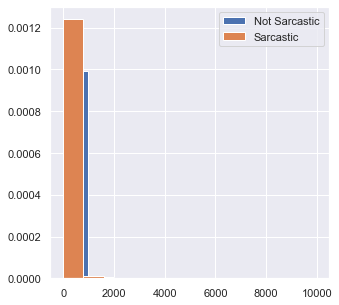

In [49]:
plotDistr('char')

In [50]:
# Number of punctuation symbols
red_copy['punct'] = red_copy['parent_comment'].str.findall(r'[^a-zA-Z\d\s:]').str.len()
red_copy.head()

,label,subreddit,parent_comment,char,punct
629463,0,beerporn,Pink beer.,10,1
55300,1,xboxone,ReCore Pancake - Joule and Mack | Xbox,38,2
680174,0,Planetside,Day...Break?,12,4
354102,0,gaming,"Just stop walking, point the gun at their head...",105,9
927917,0,funny,Pretty much like UPS.,21,1


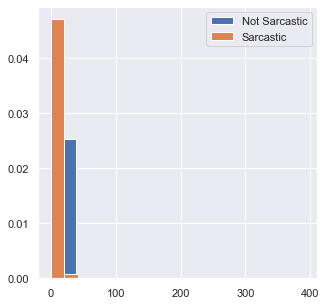

In [51]:
plotDistr('punct')

In [52]:
# Find the number of tokens for each string in the red_sample dataset
red_copy['tokens'] = red_copy['parent_comment'].str.split().str.len()
red_copy.head()

,label,subreddit,parent_comment,char,punct,tokens
629463,0,beerporn,Pink beer.,10,1,2
55300,1,xboxone,ReCore Pancake - Joule and Mack | Xbox,38,2,8
680174,0,Planetside,Day...Break?,12,4,1
354102,0,gaming,"Just stop walking, point the gun at their head...",105,9,17
927917,0,funny,Pretty much like UPS.,21,1,4


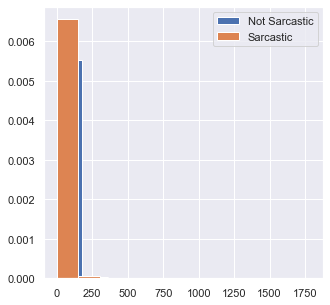

In [53]:
plotDistr('tokens')

In [54]:
# Cleaning the text of the parents' comments
stemmer = SnowballStemmer("english")

def cleanText(x):
    words = [stemmer.stem(word) for word in nltk.word_tokenize(x.lower()) if word.isalpha() and word not in stopwords.words("english")]
    return " ".join(words)

In [55]:
from timeit import default_timer as timer

# get the starting time
startTime = timer()

red_copy["clean"] = red_copy["parent_comment"].apply(cleanText)
red_copy.head()
endTime = timer()

In [56]:
# Get the time needed for stemming all the parent comments and return the cleared texts
print("Time needed to clear the comments is: {} minutes and {:.1f} seconds".format((endTime - startTime)//60, (endTime - startTime)%60))

Time needed to clear the comments is: 8.0 minutes and 52.4 seconds


## Wordcloud

WordCloud is a technique to show which words are the most frequent among the given text.
We start with only one comment:

In [57]:
red_copy.reset_index(inplace=True)
red_copy.drop(['index'], axis=1, inplace=True)
red_copy.head()

,label,subreddit,parent_comment,char,punct,tokens,clean
0,0,beerporn,Pink beer.,10,1,2,pink beer
1,1,xboxone,ReCore Pancake - Joule and Mack | Xbox,38,2,8,recor pancak joul mack xbox
2,0,Planetside,Day...Break?,12,4,1,day break
3,0,gaming,"Just stop walking, point the gun at their head...",105,9,17,stop walk point gun head click game
4,0,funny,Pretty much like UPS.,21,1,4,pretti much like up


In [58]:
red_copy.rename(columns={'parent_comment':'parent'}, inplace=True)
red_copy.head()

,label,subreddit,parent,char,punct,tokens,clean
0,0,beerporn,Pink beer.,10,1,2,pink beer
1,1,xboxone,ReCore Pancake - Joule and Mack | Xbox,38,2,8,recor pancak joul mack xbox
2,0,Planetside,Day...Break?,12,4,1,day break
3,0,gaming,"Just stop walking, point the gun at their head...",105,9,17,stop walk point gun head click game
4,0,funny,Pretty much like UPS.,21,1,4,pretti much like up


Pink beer.


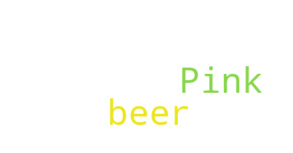

In [59]:
# Start with the first parent comment:
from wordcloud import WordCloud
parent = red_copy.parent[0]
print(parent)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(parent)

# Display the generated image:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Wordcloud on all the parent comments:

In [60]:
# Word cloud
def myWordCloud(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_copy['parent'][red_copy["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

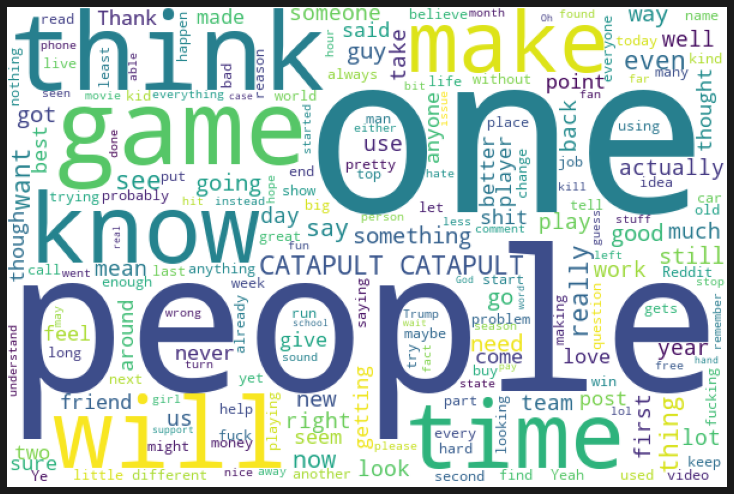

In [61]:
## Wordcloud for Non sarcastic comments
myWordCloud(0)

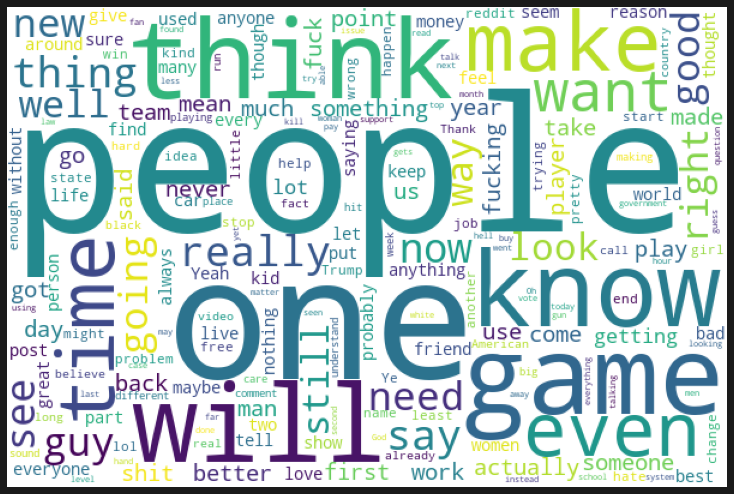

In [63]:
## Wordcloud for Sarcastic comments
myWordCloud(1)

Wordcloud with the cleaned version of the parent comments:

In [64]:
# Word cloud
def myWordCloudCleaned(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_copy['clean'][red_copy["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

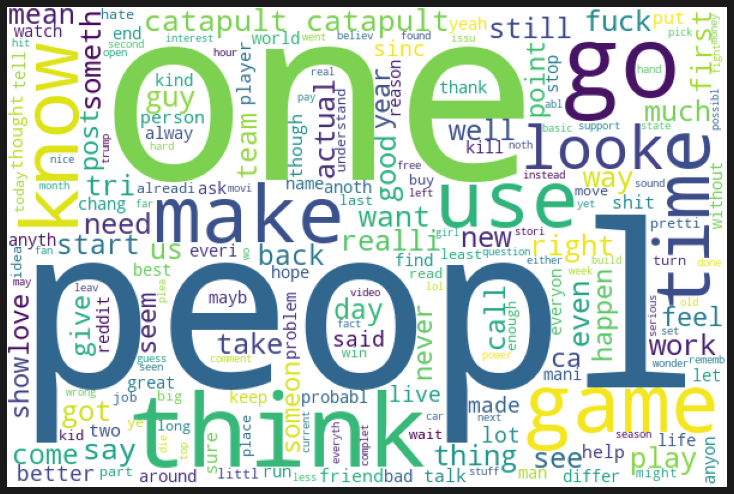

In [65]:
## Wordcloud for Non sarcastic comments
myWordCloudCleaned(0)

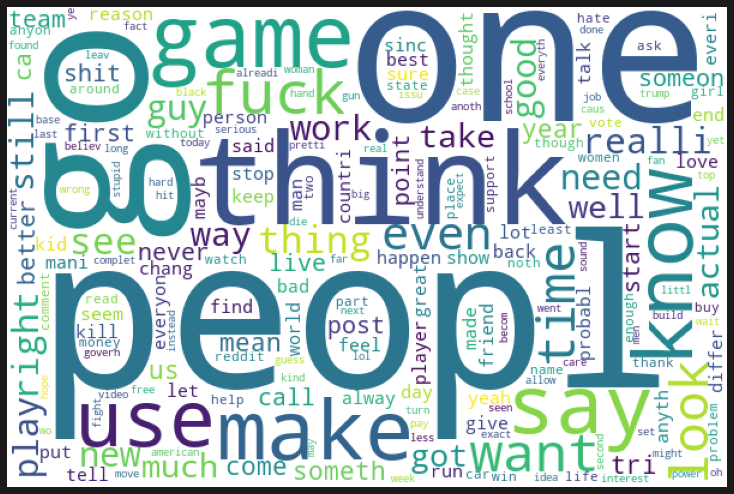

In [66]:
## Wordcloud for Sarcastic comments
myWordCloudCleaned(1)

## Split into train, test and validation set

In [67]:
## Let's check the number of unique values in the subreddit columns
red_sample['subreddit'].nunique()

4050

In [68]:
X = red_copy[['clean','subreddit']]
y = red_copy['label']

In [69]:
X_train, red_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=28)

In [70]:
red_train, red_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=28)

In [71]:
print(red_train.shape)
print(red_val.shape)
print(red_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(32344, 2)
(8087, 2)
(10108, 2)
(32344,)
(8087,)
(10108,)


In [72]:
red_train.head()

,clean,subreddit
20051,yea say game come novemb go ad bunch crap,gaming
12971,peopl reddit clan use matchmak shock news,ClashOfClans
41837,sad palestinian support use word like ethnic c...,worldnews
19748,,Pathfinder_RPG
15527,possess categori,MapPorn


In [73]:
red_val.head()

,clean,subreddit
42280,mani joke funni serious health mental situat o...,AskReddit
45359,honor rode around seattl tri ride much cobbles...,Seattle
34031,rekless said lowest teir team na pay player to...,leagueoflegends
33395,hibana special breach weapon use fresh livestream,Rainbow6
29704,competit rule renegad tdk,leagueoflegends


### TF-IDF on cleaned parent comments

TF-IDF focusing on the parent comments from which we have removed the punctuation and on which we have performed stemmization. We'll have separate Tf-Idf vectorizers for comments and for subreddits.

In [74]:
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer

In [75]:
parent_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=50000, min_df=3)
subreddits_vectorizer = TfidfVectorizer(ngram_range=(1, 1))

In [76]:
clean_train = parent_vectorizer.fit_transform(red_train['clean'])
clean_valid = parent_vectorizer.transform(red_val['clean'])
clean_test = parent_vectorizer.transform(red_test['clean'])

In [77]:
subred_train = subreddits_vectorizer.fit_transform(red_train['subreddit'])
subred_valid = subreddits_vectorizer.transform(red_val['subreddit'])
subred_test = subreddits_vectorizer.transform(red_test['subreddit'])

In [78]:
reddit_train = hstack([clean_train, subred_train])
reddit_valid = hstack([clean_valid, subred_valid])
reddit_test = hstack([clean_test, subred_test])

### Naive Bayes

In [82]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
NB = MultinomialNB()
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [80]:
naive_bayes = NB.fit(reddit_train, y_train)

In [81]:
naiveBayes_predict = NB.predict(reddit_test)

In [83]:
metrics.accuracy_score(y_test, naiveBayes_predict)

0.564800158290463

### Logistic Regression

In [84]:
logit = lg(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)

In [85]:
## Fit the model
logit.fit(reddit_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    3.7s finished


LogisticRegression(C=1, n_jobs=4, random_state=17, verbose=1)

In [86]:
from sklearn.metrics import roc_auc_score, confusion_matrix
roc_auc_score(y_test, logit.predict_proba(reddit_test)[:,1])

0.5875121111796504

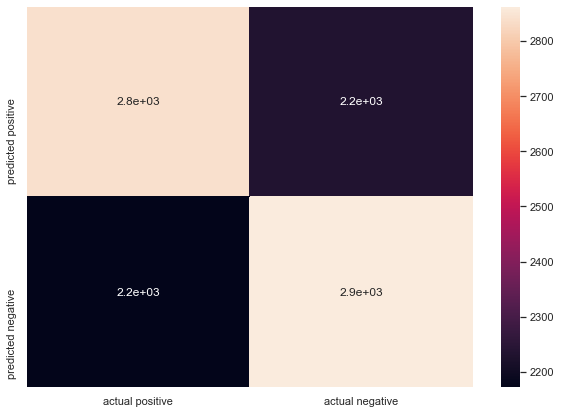

In [87]:
conf_mat = pd.DataFrame(confusion_matrix(y_test, logit.predict(reddit_test)), index = ['predicted positive', 'predicted negative'],
                  columns = ['actual positive', 'actual negative'])
plt.figure(figsize = (10,7))
sns.heatmap(conf_mat, annot=True)
plt.show()

### Random Forest

In [88]:
random_forest = RandomForestClassifier(max_depth=10, max_features=10)
random_forest.fit(reddit_train, y_train)

RandomForestClassifier(max_depth=10, max_features=10)

In [89]:
randomForest_predict = random_forest.predict(reddit_test)

In [90]:
metrics.accuracy_score(y_test, randomForest_predict)

0.5133557578155916

### GridSearch CV

In [91]:
X = red_copy[['clean','subreddit']]
y = red_copy['label']

In [92]:
X_train, X_test, y_train2, y_test2 = train_test_split(X, y, test_size=0.20, random_state=28)

In [93]:
from sklearn.model_selection import ShuffleSplit, cross_val_score

In [112]:
logistic = cross_val_score(lg, X_train, y_train2, scoring='roc_auc')
logistic

TypeError: Cannot clone object. You should provide an instance of scikit-learn estimator instead of a class.

## Alternative 2

Adding the subreddit to the comment and therefore conduct the analysis on the combination of the two: since the subreddits are not classified as stopwords when parsing the comments they should not be removed, thus appearing in the cleaned version of the comments.

In [95]:
red_copy.head()

,label,subreddit,parent,char,punct,tokens,clean
0,0,beerporn,Pink beer.,10,1,2,pink beer
1,1,xboxone,ReCore Pancake - Joule and Mack | Xbox,38,2,8,recor pancak joul mack xbox
2,0,Planetside,Day...Break?,12,4,1,day break
3,0,gaming,"Just stop walking, point the gun at their head...",105,9,17,stop walk point gun head click game
4,0,funny,Pretty much like UPS.,21,1,4,pretti much like up


In [96]:
red_copy['text'] = red_copy.clean + " " + red_copy.subreddit
red_copy.head()

,label,subreddit,parent,char,punct,tokens,clean,text
0,0,beerporn,Pink beer.,10,1,2,pink beer,pink beer beerporn
1,1,xboxone,ReCore Pancake - Joule and Mack | Xbox,38,2,8,recor pancak joul mack xbox,recor pancak joul mack xbox xboxone
2,0,Planetside,Day...Break?,12,4,1,day break,day break Planetside
3,0,gaming,"Just stop walking, point the gun at their head...",105,9,17,stop walk point gun head click game,stop walk point gun head click game gaming
4,0,funny,Pretty much like UPS.,21,1,4,pretti much like up,pretti much like up funny


In [98]:
def myWordCloudText(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_copy['text'][red_copy["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

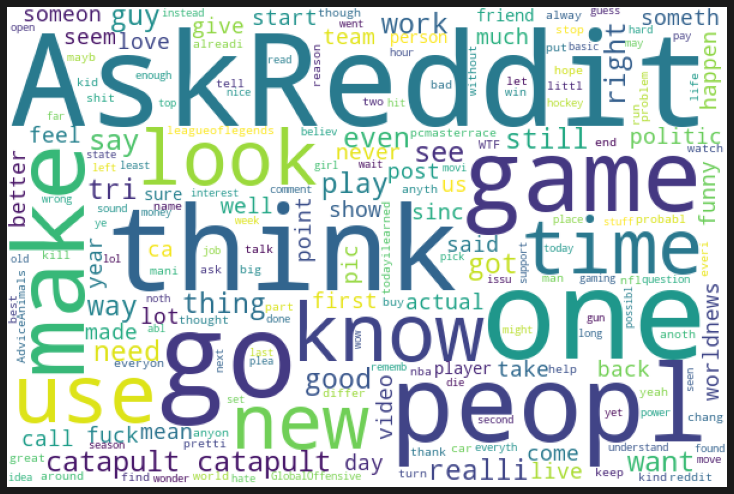

In [99]:
## Wordcloud for Non sarcastic comments
myWordCloudText(0)

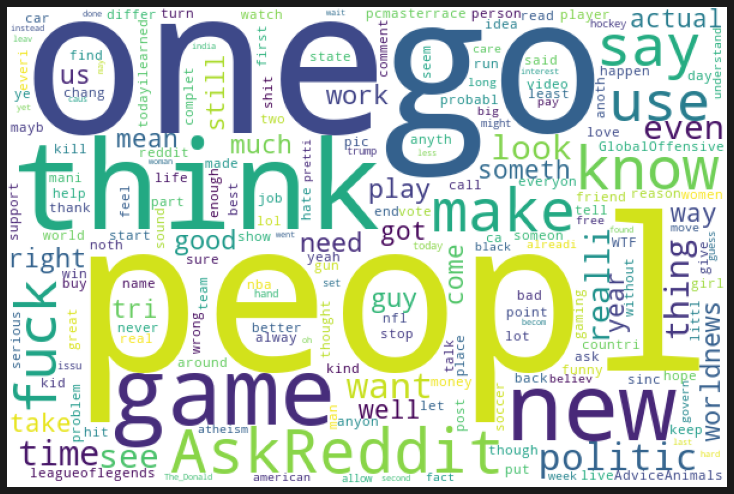

In [100]:
## Wordcloud for Non sarcastic comments
myWordCloudText(1)

In [101]:
X2 = red_copy['text']
y2 = red_copy['label']

In [102]:
X_train2, red_test2, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=28)

### Logistic Regression

In [105]:
from sklearn.pipeline import Pipeline
tf_idf2 = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# multinomial logistic regression a.k.a softmax classifier
logit = lg(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)
# sklearn's pipeline
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf2), 
                                 ('logit', logit)])

In [106]:
tfidf_logit_pipeline.fit(X_train2, y2_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    3.2s finished


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(C=1, n_jobs=4, random_state=17,
                                    verbose=1))])

In [108]:
roc_auc_score(y2_test, tfidf_logit_pipeline.predict_proba(red_test2)[:,1])

0.58964653286309

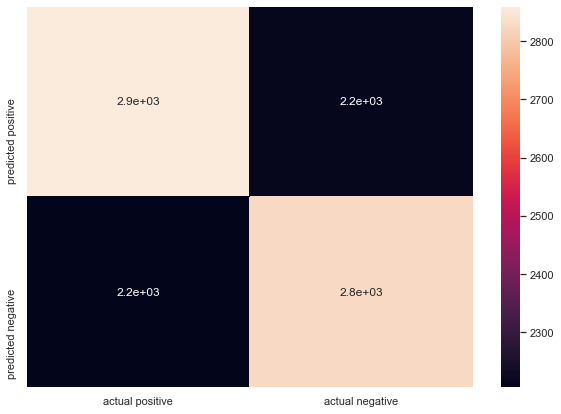

In [107]:
conf_mat2 = pd.DataFrame(confusion_matrix(y2_test, tfidf_logit_pipeline.predict(red_test2)), index = ['predicted positive', 'predicted negative'],
                  columns = ['actual positive', 'actual negative'])
plt.figure(figsize = (10,7))
sns.heatmap(conf_mat2, annot=True)
plt.show()

In [120]:
model = Pipeline([('tfidf',TfidfVectorizer(min_df=2)),
                    ('logit', lg(solver='lbfgs', max_iter=3000))])
parameters = {'tfidf__ngram_range':[(1,1),(1,2)],'tfidf__use_idf':(True,False)}

In [121]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=parameters, verbose=2,n_jobs=-1, cv=3, refit=True)

In [122]:
grid.fit(X_train2, y2_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    7.5s remaining:   15.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   13.4s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2)),
                                       ('logit',
                                        LogisticRegression(max_iter=3000))]),
             n_jobs=-1,
             param_grid={'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__use_idf': (True, False)},
             verbose=2)

In [123]:
chosen_model = Pipeline([('tfidf',TfidfVectorizer(min_df=2, ngram_range=(1,2),use_idf=True)),
                    ('logit', lg(solver='lbfgs', max_iter=3000))])
chosen_model.fit(X_train2, y2_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1, 2))),
                ('logit', LogisticRegression(max_iter=3000))])

In [127]:
from sklearn.metrics import accuracy_score
predictions = chosen_model.predict(red_test2)
print('Accuracy Score: {:.2%}'.format(accuracy_score(y2_test,predictions)),'\n')

Accuracy Score: 56.10% 



## Alternative 3

https://www.datacamp.com/community/tutorials/categorical-data

In [ ]:
category = red_copy['subreddit'].astype('category').cat.categories.tolist()
replace_sub = {'subreddit' : {k: v for k,v in zip(category, list(range(1,len(category)+1)))}}

In [ ]:
red_copy.replace(replace_sub, inplace=True)

In [ ]:
red_copy.head()

In [ ]:
# We can use hstack to merge two sparse matrices, without having to convert to dense format.
def addFeature(X, feature_to_add):  
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [ ]:
R = addFeature(R, red_train['subreddit'])

In [ ]:
features = np.append(parent_vectorizer.get_feature_names(), ['Sub'])

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
selector = SelectKBest(chi2, k=20) 
R_new = selector.fit_transform(R, y_train)
print(R_new.shape)

In [ ]:
features[selector.get_support()]

In [ ]:
# compute chi2 scores for features and sort them from most to less relevant
from sklearn.feature_selection import chi2
stat, pval = chi2(R,y_train)
score = list(zip(features, stat, pval))
score.sort(key = lambda tup: tup[2])
score

In [ ]:
# select features with p-val less than 1%
sel = np.flatnonzero(pval < 0.01)
R_sel = R[:,sel]
features_sel = features[sel]
R_sel

In [ ]:
# Scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
R_scale = scaler.fit_transform(R_sel.toarray())

### PCA Analysis for dimensionality reduction

In [ ]:
# PCA
from sklearn.decomposition import PCA

pca = PCA().fit(R_scale)
nc  = list(range(1,1+len(pca.explained_variance_ratio_)))
ev  = np.cumsum(pca.explained_variance_ratio_)
plt.plot(nc, ev)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()